In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle
from src.data_tools.get_data import get_data

In [2]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
from src.plotting_tools.draw_stack_plot_hists import draw_bckground, draw_signals, draw_data, draw_stackplot
from src.plotting_tools.SysHist import SysHist
from src.plotting_tools.Bins import Bins
from src.plotting_tools.utils import ratio_plot_template

In [5]:
from src.general.array_utils import moving_average, moving_sum, super_sample, super_sample_function, moving_avg_func, unp_array_to_nom_std
from src.plotting_tools.cms_format import cms_style, cms_format_fig

In [6]:
cms_style()

In [7]:
era = '2016'
df, lumi = get_data(era, df_filter=lambda x: x.type.str.contains('bck'))

In [8]:
df.type.unique()

array(['bck', 'bck_ext'], dtype=object)

In [9]:
#df = df[df.Weight < 10]

In [25]:
#df = df[ ~ df.category.str.contains('DY')]

Text(0, 1, 'EventWeight')

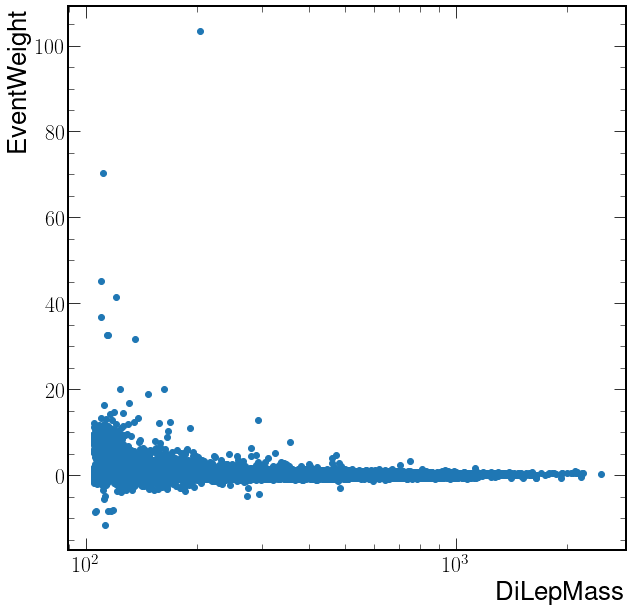

In [11]:
plt.scatter(df.DiLepMass, df.Weight )
plt.xscale('log')
plt.xlabel('DiLepMass')
plt.ylabel('EventWeight')

In [24]:
bins = Bins(np.linspace(105,900, int((900-105)/5+1)))
#bins = Bins(np.linspace(105,900, 100))

bins

[105. 110. 115. 120. 125. 130. 135. 140. 145. 150. 155. 160. 165. 170.
 175. 180. 185. 190. 195. 200. 205. 210. 215. 220. 225. 230. 235. 240.
 245. 250. 255. 260. 265. 270. 275. 280. 285. 290. 295. 300. 305. 310.
 315. 320. 325. 330. 335. 340. 345. 350. 355. 360. 365. 370. 375. 380.
 385. 390. 395. 400. 405. 410. 415. 420. 425. 430. 435. 440. 445. 450.
 455. 460. 465. 470. 475. 480. 485. 490. 495. 500. 505. 510. 515. 520.
 525. 530. 535. 540. 545. 550. 555. 560. 565. 570. 575. 580. 585. 590.
 595. 600. 605. 610. 615. 620. 625. 630. 635. 640. 645. 650. 655. 660.
 665. 670. 675. 680. 685. 690. 695. 700. 705. 710. 715. 720. 725. 730.
 735. 740. 745. 750. 755. 760. 765. 770. 775. 780. 785. 790. 795. 800.
 805. 810. 815. 820. 825. 830. 835. 840. 845. 850. 855. 860. 865. 870.
 875. 880. 885. 890. 895. 900.]

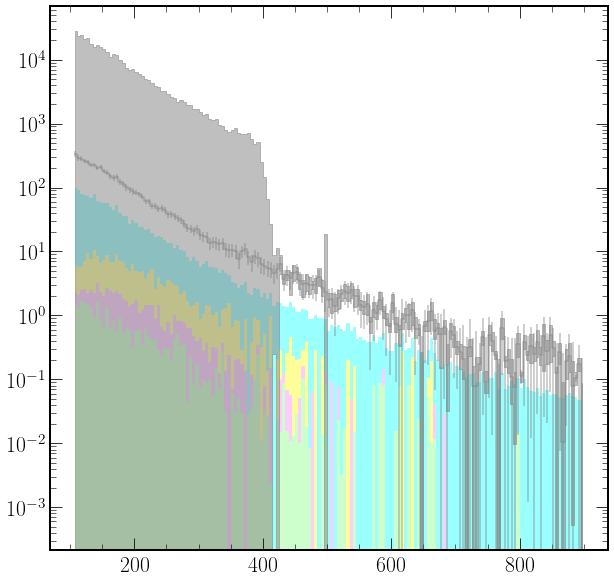

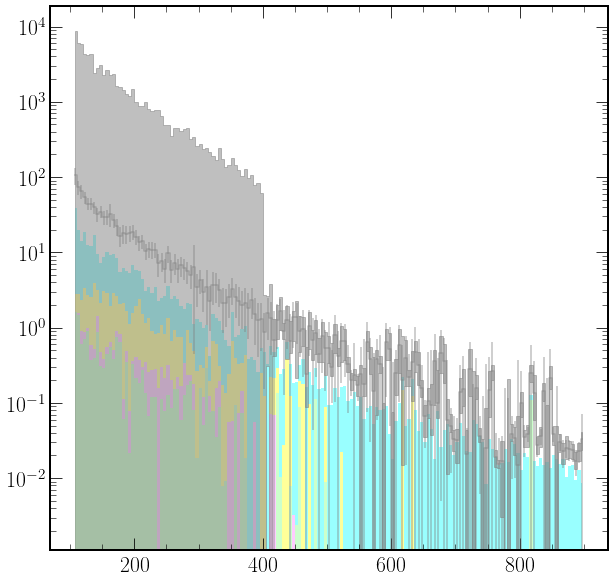

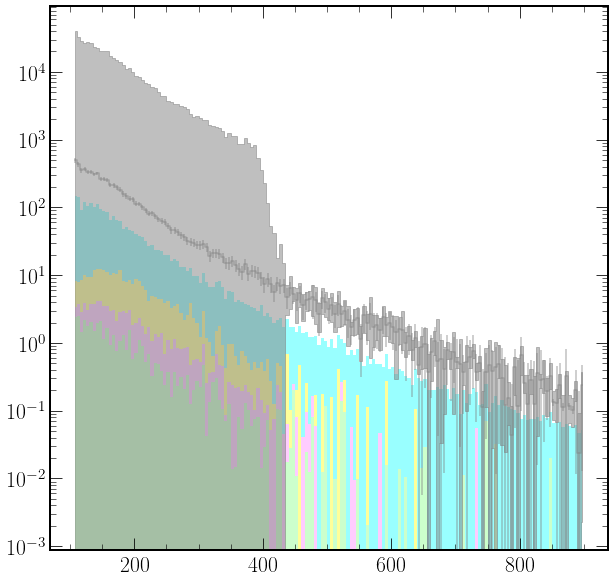

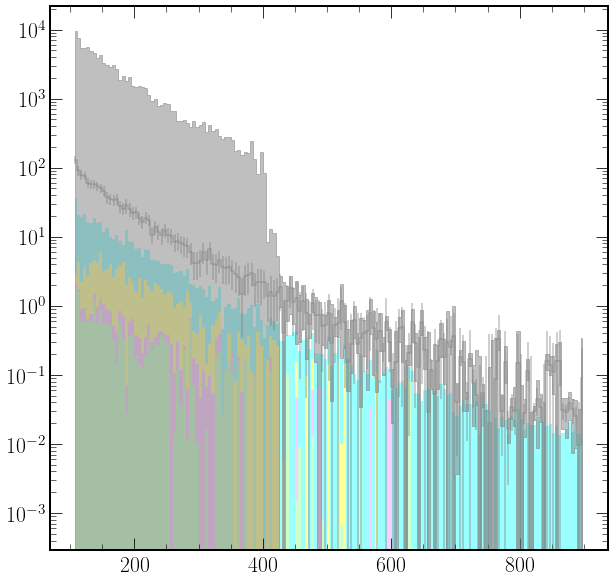

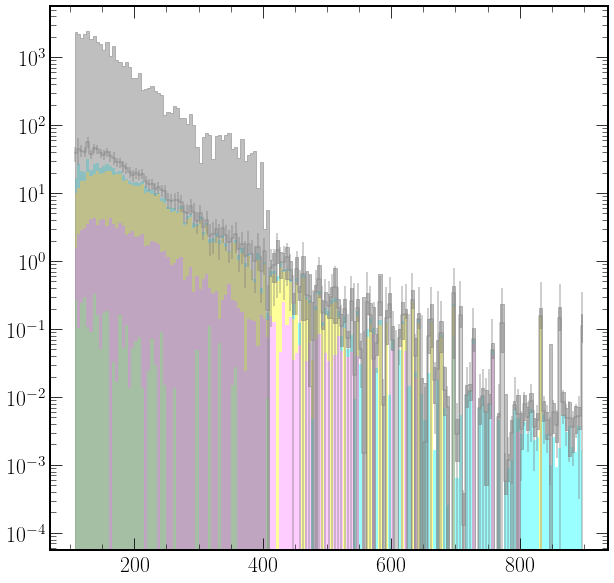

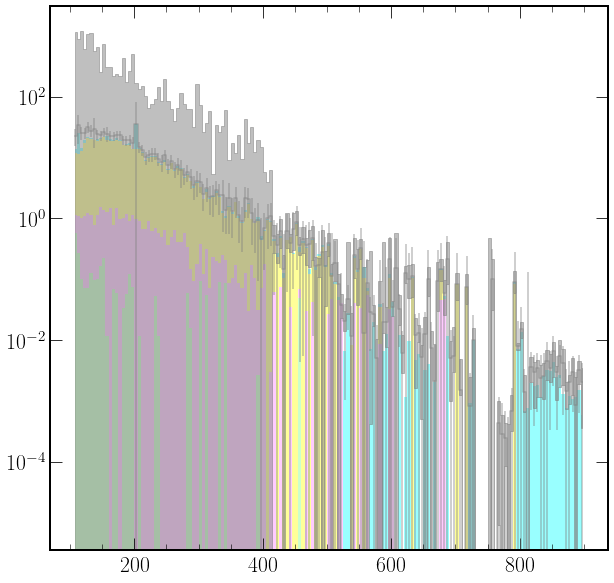

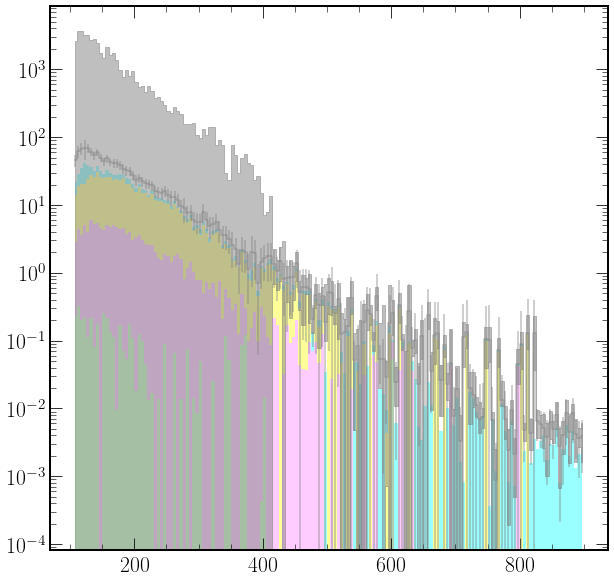

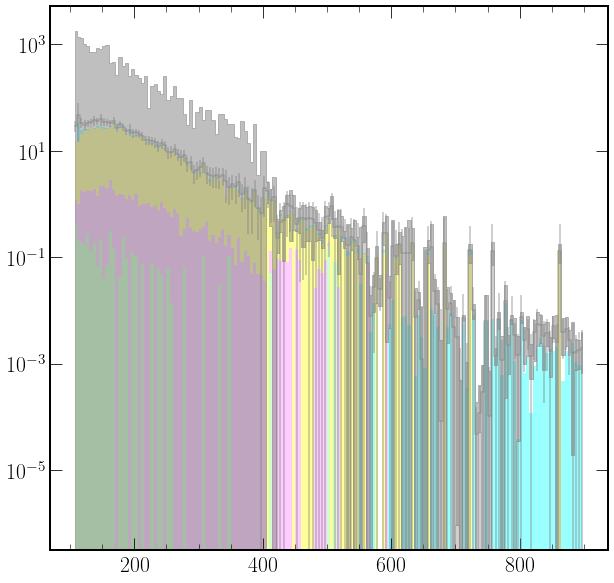

In [26]:
mc_hists = {}
for reg in ['CR14','CR24', 'CR10','CR20', 'CR13', 'CR23', 'SR1', 'SR2']:
    fig, ax = plt.subplots(1)
    mc_hists[reg] = draw_bckground(ax, df, 'DiLepMass', reg, era, bin_edges=bins.bin_edges)
    ax.set_yscale('log')

In [14]:
def open_and_convert_plotting_dict(fn):
    with open(fn, 'rb') as f:
        plot_dict= pickle.load(f)
        
    for reg in plot_dict:
        if 'hist' in plot_dict[reg]:
            plot_dict[reg]['hist'] = SysHist.from_dict(plot_dict[reg]['hist'])
        plot_dict[reg]['fit'] = SysHist.from_dict(plot_dict[reg]['fit'])
    return plot_dict

In [15]:
plot_dict_mc = open_and_convert_plotting_dict('fits/limit_setting/plot_dict_mc_{}.pkl'.format(era))
plot_dict = open_and_convert_plotting_dict('fits/limit_setting/plot_dict_data_{}.pkl'.format(era))

In [16]:
def compare_hists(hist1, hist2, ismc = False, n=10, ndof=0, **kwargs):
    fig, ax, rax = ratio_plot_template(figsize=(10,10))
    hist1.draw(ax)
    hist2.draw(ax, color='red', draw_sys=False)
    
    x = hist1.calc_bin_centers()

    rax.plot(x, np.full(len(x), 1) , color='black', linestyle=':')
    rax.plot(x, np.full(len(x), 0) , color='black')
    rax.plot(x, np.full(len(x), -1) , color='black', linestyle=':')
    
    cms_format_fig(era, ax)
    ax.set_yscale('Log')
    ax.set_ylabel('Counts per GeV')
    rax.set_xlabel('DiLepMass [GeV]')
    rax.set_ylim(-5,5)
    rax.set_ylabel('Pull')
    
    nom1_avg = moving_sum(hist1.nominal, n = n)
    nom2_avg = moving_sum(hist2.nominal, n = n)
    var1_avg = moving_sum(hist1.std**2, n = n)
    var2_avg = moving_sum(hist2.std**2, n = n)
    x_avg = moving_average(x, n=n)
    if ismc:
        pull = (nom1_avg-nom2_avg)/(var2_avg+var1_avg)**.5
    else:
        pull = (nom1_avg-nom2_avg)/nom1_avg**.5
    pullsquare = pull**2
    
    rax.plot(x_avg, pull)
    
    return  {'chi2': (pullsquare).sum()/(hist1.calc_nBins()-ndof),
             'fig': fig,
             'ax': ax,
             'rax': rax}
    

In [108]:
from scipy.optimize import curve_fit
from src.general.functions import power_func, power_law, make_bpoly, linear, parabola, make_bpoly_log

/cvmfs/cms.cern.ch/slc7_amd64_gcc900/external/py3-scipy/1.7.1-c59502069094870046fda47cb5a5065e/lib/python3.9/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


In [18]:
from scipy.optimize import curve_fit
from src.general.functions import make_bpoly, lognorm
from src.plotting_tools.SysHist import SysHist

In [19]:
import uncertainties
import uncertainties.unumpy as unp

In [20]:
def fit_hist(func, hist, n=10, comp_hist_n =10, do_super_sample=1, ismc=False, **kwargs):
    dhist = hist

    x = np.array(dhist.calc_bin_centers())
    x_avg = moving_average(x, n = n)
    values = dhist.uncertainty_std_dev()
    value_sum = moving_sum(values, n = n)
    nom_sum, std_sum = unp_array_to_nom_std(value_sum)
    popt, pcov = curve_fit(func, x_avg, nom_sum, 
                       **kwargs,
                       sigma=std_sum, maxfev = int(1e6))  
    #create fit values with uncertainties
    try:
        popt_unc = uncertainties.correlated_values(popt, pcov)
    except:
        pcov = np.full(pcov.shape, 1)
        popt_unc = uncertainties.correlated_values(popt, pcov)
    if do_super_sample:
        y = super_sample(lambda _x: func(_x, *popt_unc, module=unp), hist.bin_edges, n_samples=3e3)
        y = y/(y.sum())*hist.calc_sum()
        fit_hist = SysHist(
            y,
            x*0, x*0, 
            y**.5,
            np.array(hist.bin_edges)
        )
    else: 
        y = func(x, *popt_unc, module=unp)/n
        y_nom, y_std = unp_array_to_nom_std(y)
        if sum(y_std) > sum(y_nom): y_std = y_nom**.5
        fit_hist = SysHist(
            y_nom,
            x*0, x*0, 
            y_std,
            np.array(hist.bin_edges)
        ).normalize().calc_ratio(1/hist.calc_sum())

    compare_dict = compare_hists(fit_hist, hist, ismc=ismc, n=comp_hist_n, ndof=5)
    return {**compare_dict, 
            "popt" : popt,
            "fit_hist": fit_hist
           }

In [127]:
def fit_hist(func, hist, n=10, comp_hist_n =10, do_super_sample=1, ismc=False,  do_unc=1, **kwargs):
    x = np.array(hist.calc_bin_centers())
    popt, pcov = curve_fit(func, x, hist.nominal, 
                       **kwargs,
                       sigma=hist.std, maxfev = int(1e6))  
    if do_unc:
        #create fit values with uncertainties
        popt_unc = uncertainties.correlated_values(popt, pcov)
        #make_fit_hist
        y = func(x, *popt_unc, module=unp)
        y_nom, y_std = unp_array_to_nom_std(y)
    else: 
        y_nom = func(x, *popt)
        varper = ((hist.nominal-y_nom)**2/y_nom).mean()
        y_std = (varper*y_nom)**.5
        y_std = y_nom*.1
    fit_hist = SysHist(
            y_nom,
            x*0, x*0, 
            y_std,
            np.array(hist.bin_edges)
        ).normalize().calc_ratio(1/hist.calc_sum())

    compare_dict = compare_hists(fit_hist, hist, ismc=ismc, n=comp_hist_n, ndof=5)
    return {**compare_dict, 
            "popt" : popt,
            "fit_hist": fit_hist
           }

In [128]:
bottom_value = 120
top_value=500

In [129]:
fit_met_dict = {
'2016':{
    1:{
        'CR14': {'n':1, "p0": [5.17589200e+05, 8.78218612e-01, 6.16752197e+01, 1.18227681e+02]},
        'CR24': {'n':1, "p0": [ 4.41760319e+53,  3.84762314e+00,  5.76974918e-23, -1.08832717e+02]},
        'CR10': {'n':1, "p0": [1.18254639e+07, 8.82943578e-01, 3.22363762e+01, 1.11002528e+01]},
        'CR20': {'n':1, "p0": [3.95574700e+04, 8.75397073e-01, 7.45223435e+01, 1.0e+02]},
        'CR13': {'n':1, "p0": [3.95574700e+04, 8.75397073e-01, 7.45223435e+01, 1.35552128e+02]},
        'CR23': {'n':1, "p0": [ 3.01888637e+53,  1.25150625e+00,  7.18030598e-06, 5]},
    }
},
'2017':{
    1:{
        'CR14': {'n':1, "p0": [7.74879312e+03, 9.40193778e-01, 3.16798508e+01, 3.83308634e+01]},
        'CR24': {'n':2, "p0": [7.74879312e+03, 9.40193778e-01, 3.16798508e+01, 3.83308634e+01]},
        'CR10': {'n':1, "p0": [1.18254639e+07, 8.82943578e-01, 3.22363762e+01, 1.11002528e+01]},
        'CR20': {'n':3, "p0": [ 1.46554335e+03,  7.16342950e-01,  4.20014486e+01, -1.73370333e+02]},
        'CR13': {'n':1, "p0": [7.74879312e+03, 9.40193778e-01, 3.16798508e+01, 3.83308634e+01]},
        'CR23': {'n':1, "p0": [7.74879312e+03, 9.40193778e-01, 3.16798508e+01, 3.83308634e+01], 'comp_hist_n':2},
    }
},
'2018':{
    1:{
        'CR14': {'n':1, "p0": [1.96247619e+07, 1.01716162e+00, 1.62832427e+01, 1.48315991e+00]},
        'CR24': {'n':1, "p0": [8.03727359e+05, 9.02274844e-01, 5.26287394e+01, 5.21743812e+01]},
        'CR10': {'n':2, "p0": [ 5.56107508e+12,  1.35175433e+00,  2.36597519e-01, -9.14860278e+01]},
        'CR20': {'n':2, "p0": [5.31656559e+04, 8.93718022e-01, 7.45883394e+01, 10]},
        'CR13': {'n':1, "p0": [4.44170392e+04, 6.90224547e-01, 8.10176445e+01, 90], 'bounds': ([-np.inf,-np.inf,-np.inf, -np.inf], [np.inf,np.inf,np.inf, bottom_value])},
        'CR23': {'n':1, "p0": [1.14663512e+05, 5.27827787e-01, 1.16081858e+02, 4.54731422e+01], 'bounds': ([-np.inf,-np.inf,-np.inf, -np.inf], [np.inf,np.inf,np.inf, bottom_value])},
    }
}
    
}

CR14 0.3838709673016776 array([1.81037510e+04, 8.41964717e-01, 6.40471521e+01, 9.23284346e+01])
CR24 0.4759351501381805 array([3.26976347e+03, 8.67050642e-01, 6.71993744e+01, 7.10422933e+01])
CR10 0.2980461779791531 array([2.55797345e+04, 8.45415284e-01, 6.30280820e+01, 9.70953490e+01])


/afs/cern.ch/work/r/rymuelle/public/nanoAODzPrime/CMSSW_12_1_0/src/bff_plotting_code_v3/src/general/functions.py:91: RuntimeWarning: invalid value encountered in log
  ### limit plotting


CR20 0.5321925371177448 array([ 4.55905247e+03,  1.76652334e+00,  1.05839994e-06, -3.08734629e+02])
CR13 1.2191845583527923 array([ 3.77582339e+03,  4.28571191e-01,  1.48819211e+02, -2.42058403e+01])


/afs/cern.ch/work/r/rymuelle/public/nanoAODzPrime/CMSSW_12_1_0/src/bff_plotting_code_v3/src/general/functions.py:91: RuntimeWarning: invalid value encountered in log
  ### limit plotting


CR23 0.8292770406077328 array([2.81754275e+03, 4.38021687e-01, 1.47049821e+02, 9.87322499e+00])


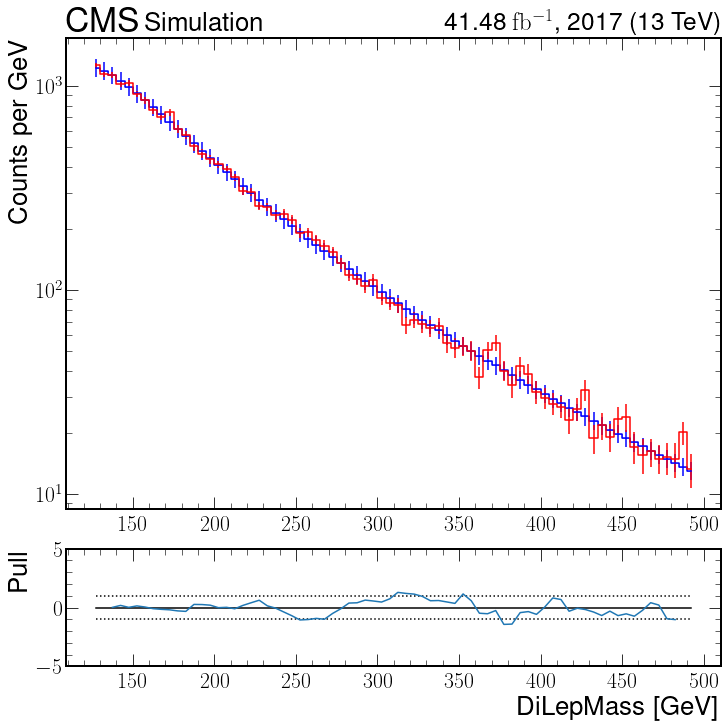

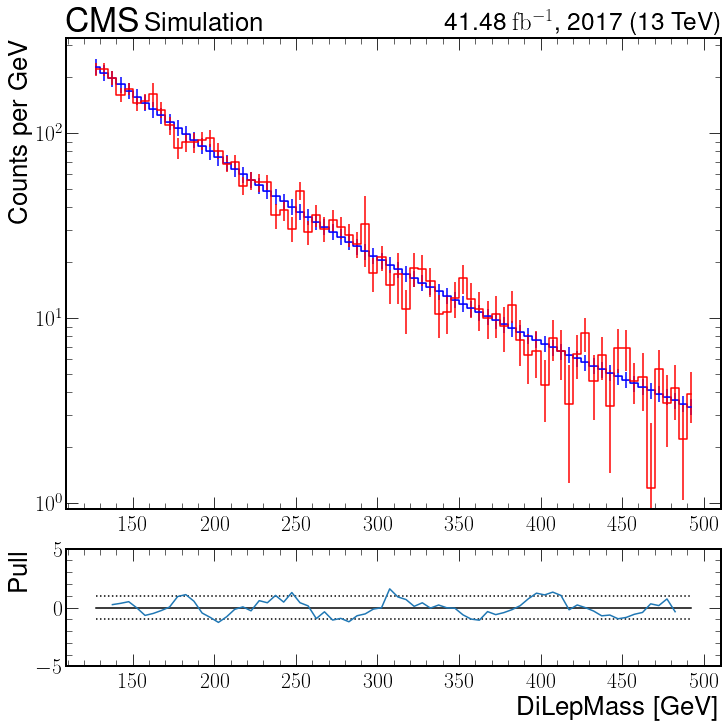

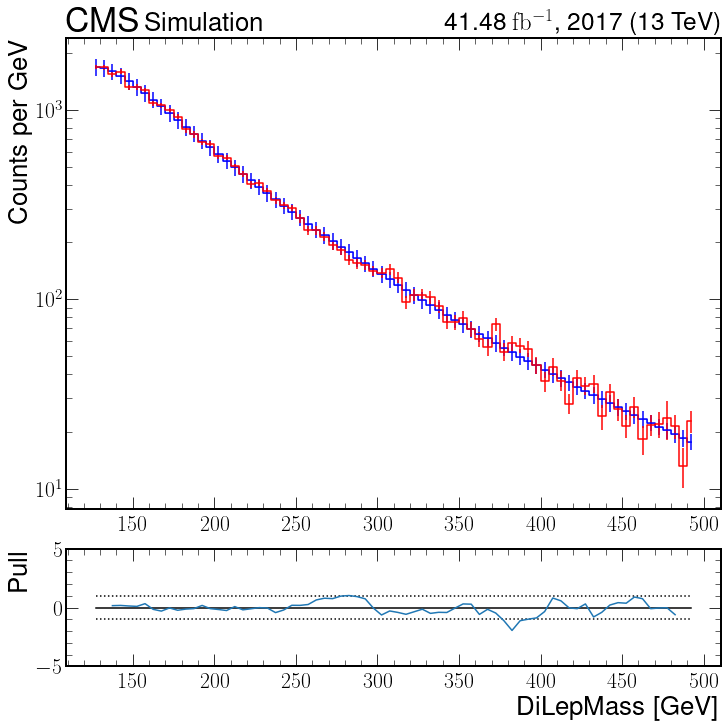

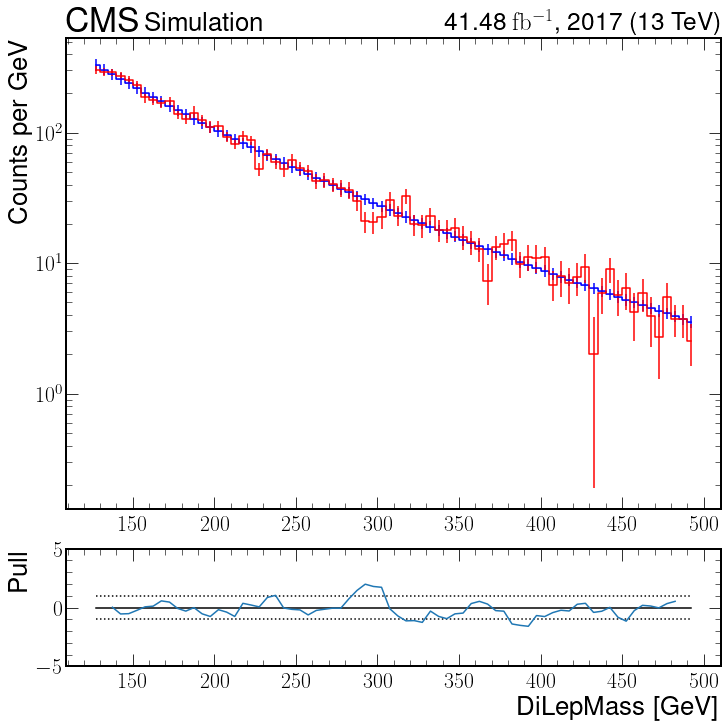

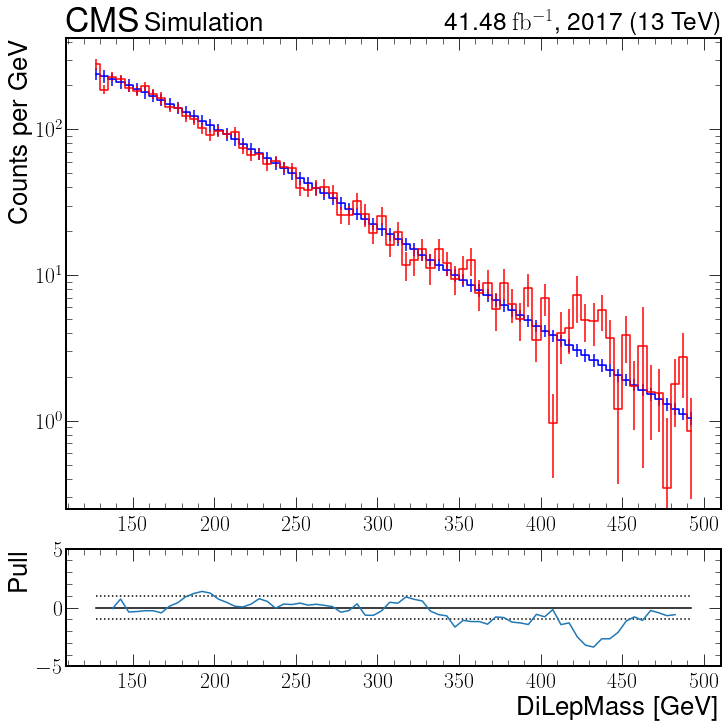

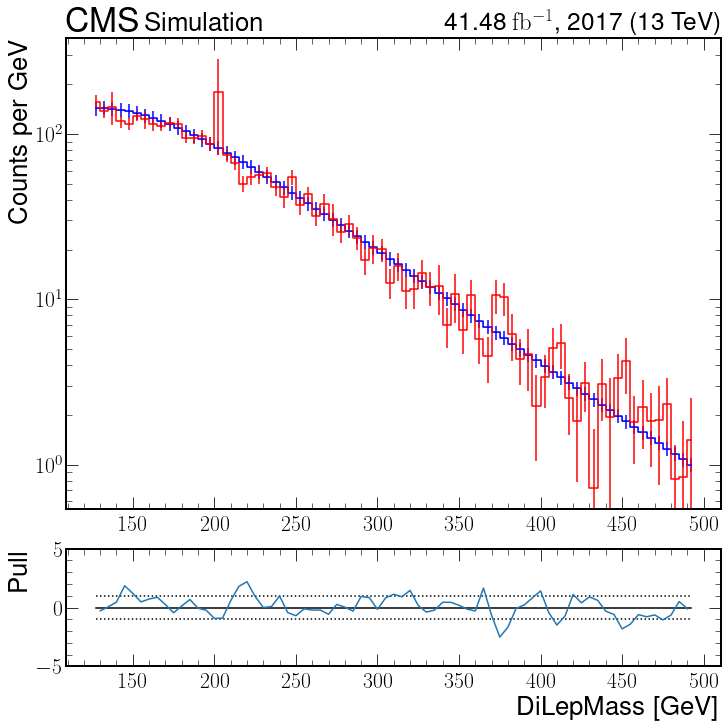

In [130]:
fit_dict = {}
ismc=1
for reg, reg_dict in fit_met_dict[era][ismc].items():
    #if reg != 'CR10': continue
    n = reg_dict['n']
    p0 = reg_dict['p0']
    comp_hist_n = 5
    if 'comp_hist_n' in reg_dict:
        comp_hist_n = reg_dict['comp_hist_n']
    bounds = ([-np.inf,-np.inf,-np.inf, -np.inf], [np.inf,np.inf,np.inf, bottom_value])
    if 'bounds' in reg_dict:  bounds = reg_dict['bounds']        
              
    _plot_dict = mc_hists[reg]

    hist = mc_hists[reg].reduce_range(bottom=bottom_value, top=top_value)

    curve_fit_chi2 = fit_hist(lognorm, hist, n=n, comp_hist_n=comp_hist_n, do_super_sample=0, 
                              ismc=True, p0=p0,
                              bounds = bounds,
                              do_unc=0
                             )
    fit_dict[reg] = curve_fit_chi2
    print(reg, curve_fit_chi2['chi2'],  repr(curve_fit_chi2['popt']))
    curve_fit_chi2['fig'].savefig('fits/curve_fit_closure_test_22/fit_era{}_ismc{}_reg{}_bottom{}.pdf'.format(era,ismc,reg,bottom_value))

1 {'chi2': 1.9328089512173114, 'fig': <Figure size 720x720 with 2 Axes>, 'ax': <AxesSubplot:ylabel='Counts per GeV'>, 'rax': <AxesSubplot:xlabel='DiLepMass [GeV]', ylabel='Pull'>}
2 {'chi2': 1.0855966928245893, 'fig': <Figure size 720x720 with 2 Axes>, 'ax': <AxesSubplot:ylabel='Counts per GeV'>, 'rax': <AxesSubplot:xlabel='DiLepMass [GeV]', ylabel='Pull'>}


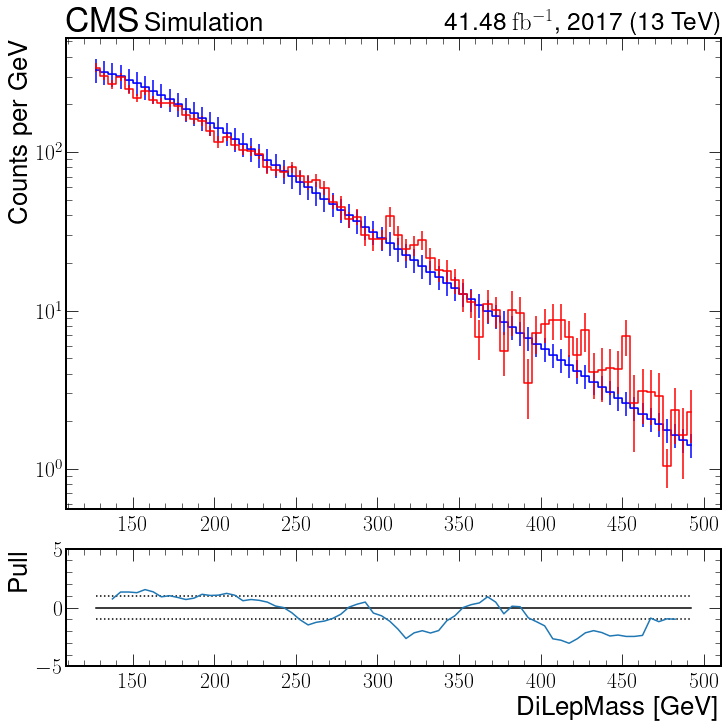

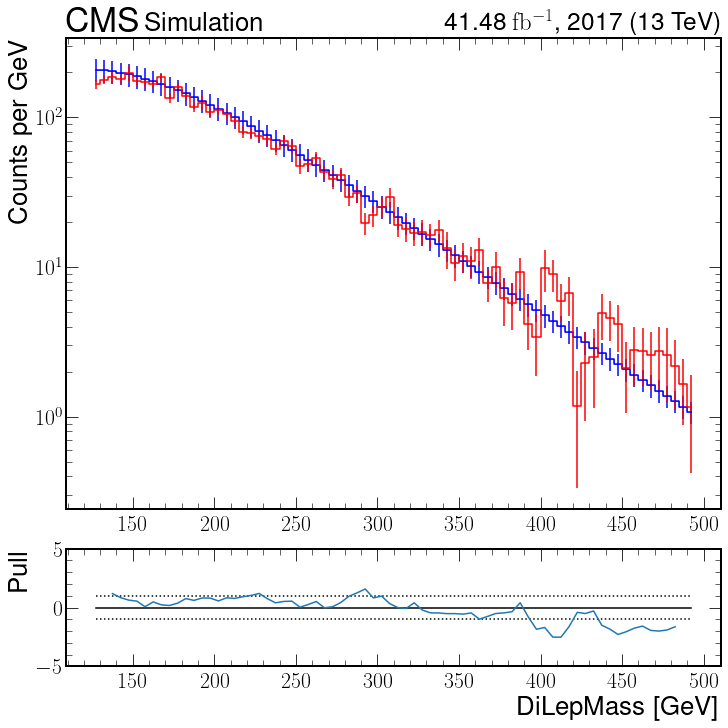

In [131]:
for nJets in [1,2]:
    A = fit_dict['CR{}0'.format(nJets)]['fit_hist']
    B = fit_dict['CR{}3'.format(nJets)]['fit_hist']
    C = fit_dict['CR{}4'.format(nJets)]['fit_hist']

    abcd = A.uncertainty_std_dev()*B.uncertainty_std_dev()/C.uncertainty_std_dev()
    abcd_nom, abcd_std = unp_array_to_nom_std(abcd)
    hist = mc_hists['SR{}'.format(nJets)].reduce_range(bottom=bottom_value, top=top_value)
    abcd_hist = SysHist(abcd_nom, abcd_nom*0,abcd_nom*0,abcd_std, hist.bin_edges)
    abcd_hist = abcd_hist
    compare_hist_dict = compare_hists(abcd_hist, hist, ismc=True, n=5)
    compare_hist_dict['fig'].savefig('fits/curve_fit_closure_test_22/abcd_era{}_ismc{}_regSR{}_bottom{}.pdf'.format(era,ismc,nJets,bottom_value))
    fit_dict['SR{}'.format(nJets)]= compare_hist_dict
    print(nJets, compare_hist_dict)

CR14 0.4816639129978331 array([ 7.5140379 ,  3.52646108, -1.68618692,  8.45677478])
CR24 0.47887669667014815 array([ 5.79226086,  1.3977923 , -0.43909312,  0.70721157])
CR10 0.7254015045862069 array([ 7.86164649,  3.86725786, -1.26972223,  7.85022949])
CR20 0.5095482526483928 array([ 6.19222565,  1.4485352 ,  0.9014111 , -4.20975606])
CR13 1.3049186735628076 array([ 5.68952162,  3.45080255, -6.56756472,  3.59890812])
CR23 0.8040585262163714 array([  4.99775199,   4.93795874, -11.22014722,  15.69901641])


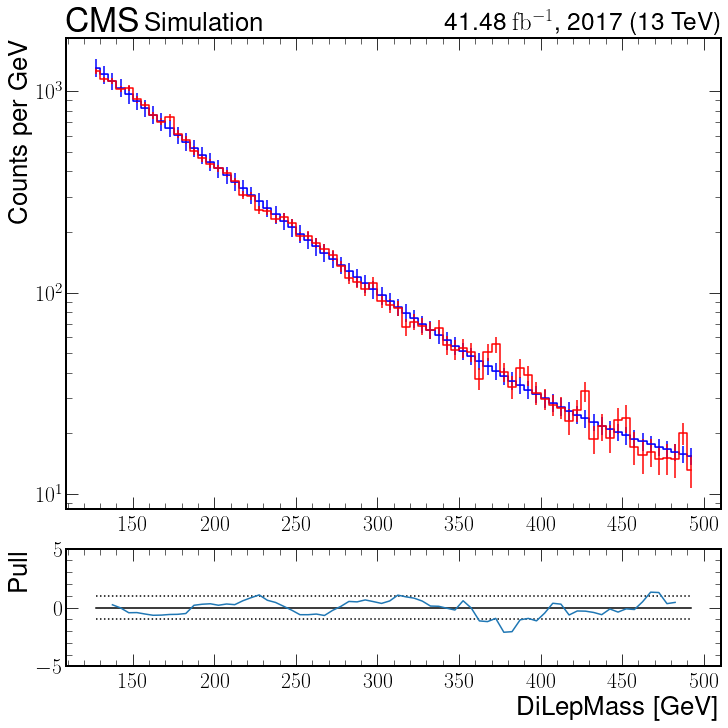

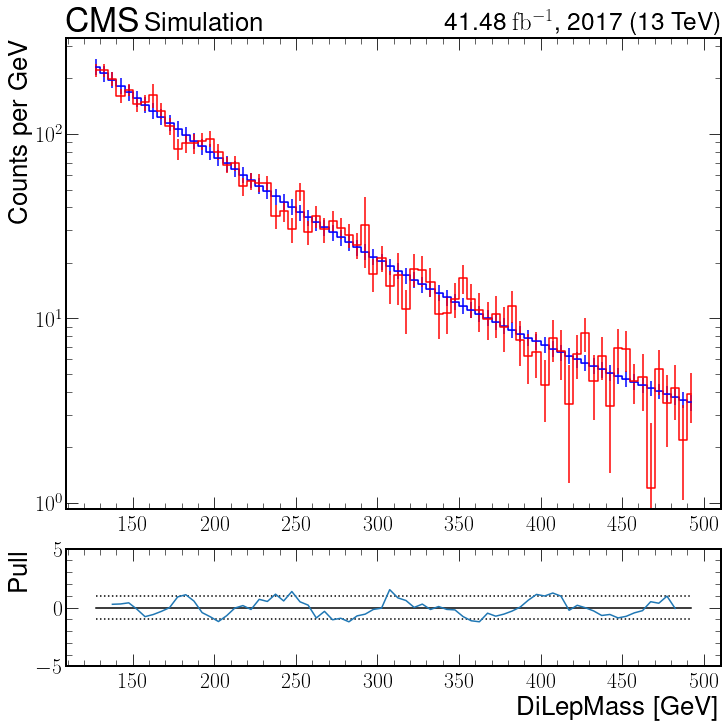

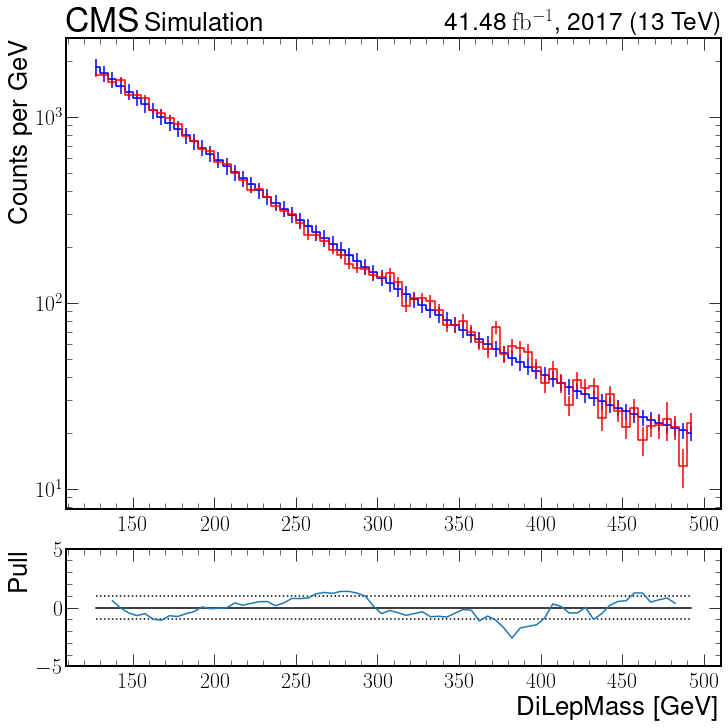

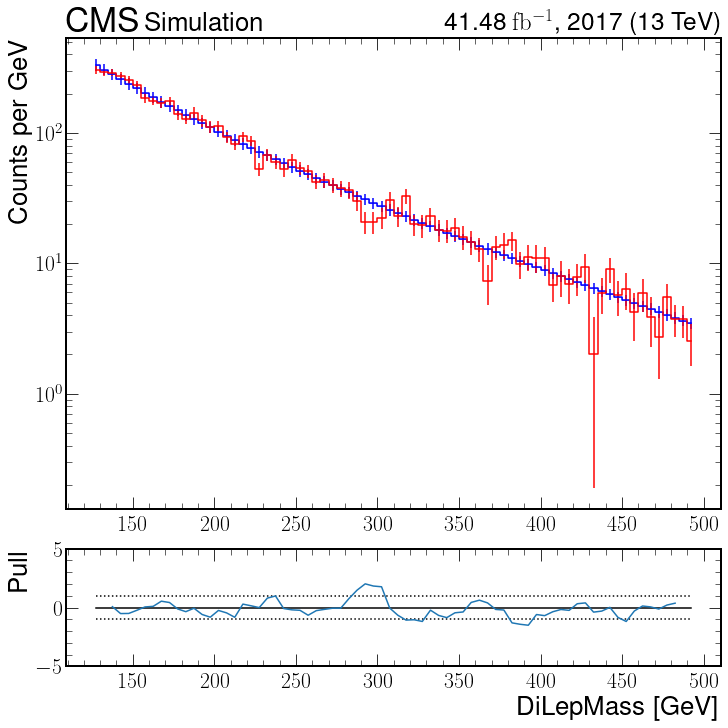

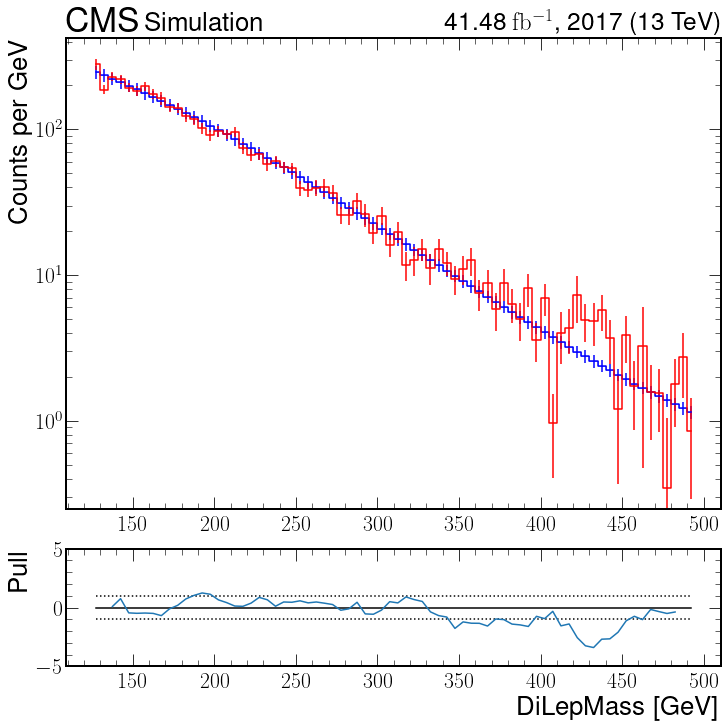

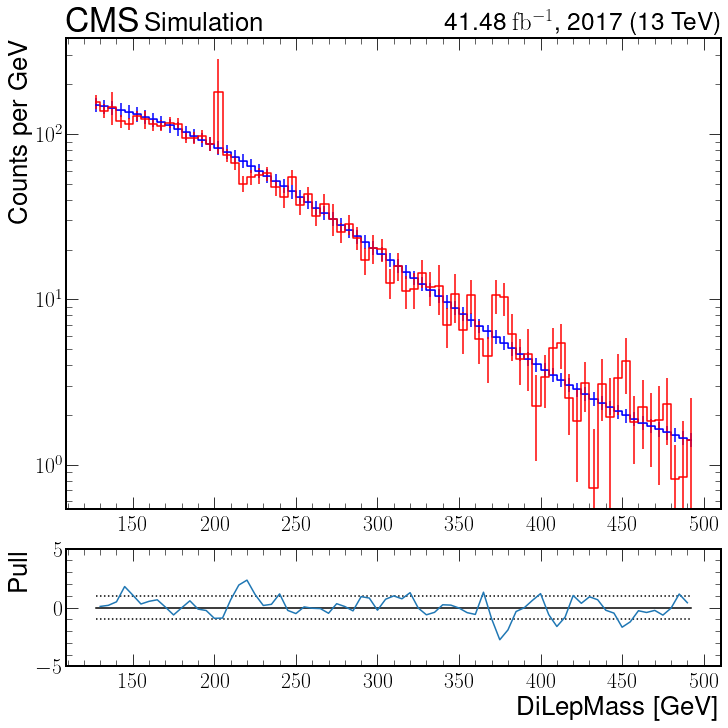

In [132]:
fit_dict = {}
ismc=1
for reg, reg_dict in fit_met_dict[era][ismc].items():
    #if reg != 'CR10': continue
    n = reg_dict['n']
    p0 = reg_dict['p0']
    comp_hist_n = 5
    if 'comp_hist_n' in reg_dict:
        comp_hist_n = reg_dict['comp_hist_n']
    bounds = ([-np.inf,-np.inf,-np.inf, -np.inf], [np.inf,np.inf,np.inf, bottom_value])
    if 'bounds' in reg_dict:  bounds = reg_dict['bounds']        
              
    _plot_dict = mc_hists[reg]

    hist = mc_hists[reg].reduce_range(bottom=bottom_value, top=top_value)

    curve_fit_chi2 = fit_hist(make_bpoly_log, hist, n=n, comp_hist_n=comp_hist_n, do_super_sample=0, 
                              ismc=True, p0=[1,1, 1, 1],
                              do_unc=0
                             )
    fit_dict[reg] = curve_fit_chi2
    print(reg, curve_fit_chi2['chi2'],  repr(curve_fit_chi2['popt']))
    curve_fit_chi2['fig'].savefig('fits/curve_fit_closure_test_22/fit_era{}_ismc{}_reg{}_bottom{}_bernstein.pdf'.format(era,ismc,reg,bottom_value))

1 {'chi2': 1.8842873370730167, 'fig': <Figure size 720x720 with 2 Axes>, 'ax': <AxesSubplot:ylabel='Counts per GeV'>, 'rax': <AxesSubplot:xlabel='DiLepMass [GeV]', ylabel='Pull'>}
2 {'chi2': 1.0285399891347964, 'fig': <Figure size 720x720 with 2 Axes>, 'ax': <AxesSubplot:ylabel='Counts per GeV'>, 'rax': <AxesSubplot:xlabel='DiLepMass [GeV]', ylabel='Pull'>}


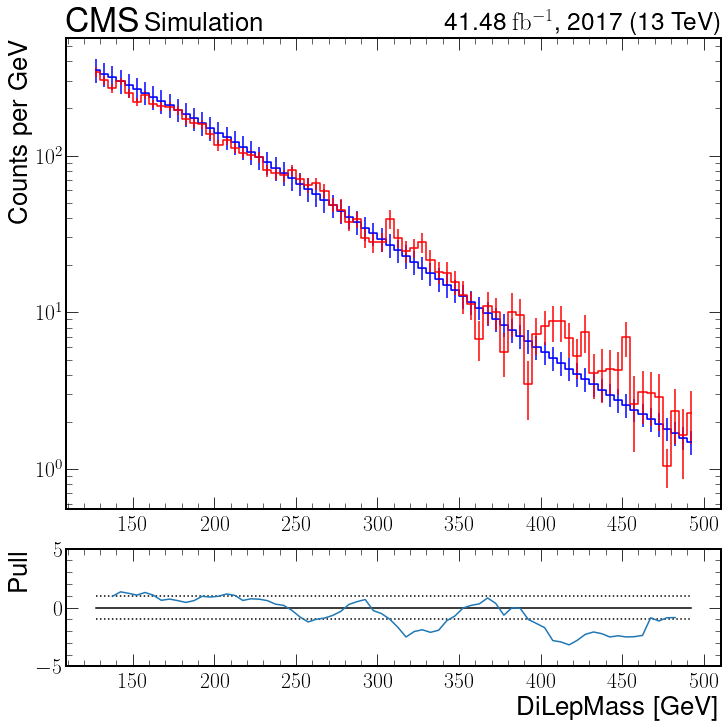

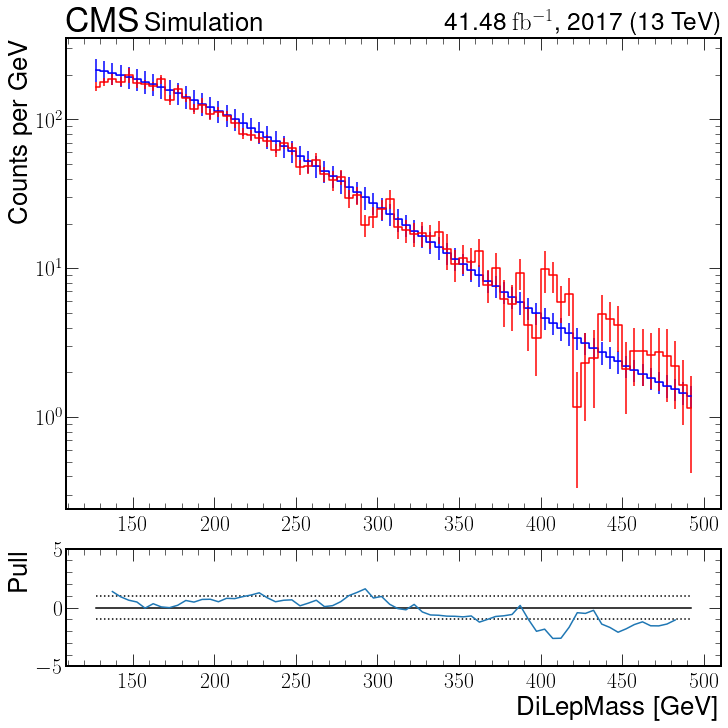

In [134]:
for nJets in [1,2]:
    A = fit_dict['CR{}0'.format(nJets)]['fit_hist']
    B = fit_dict['CR{}3'.format(nJets)]['fit_hist']
    C = fit_dict['CR{}4'.format(nJets)]['fit_hist']

    abcd = A.uncertainty_std_dev()*B.uncertainty_std_dev()/C.uncertainty_std_dev()
    abcd_nom, abcd_std = unp_array_to_nom_std(abcd)
    hist = mc_hists['SR{}'.format(nJets)].reduce_range(bottom=bottom_value, top=top_value)
    abcd_hist = SysHist(abcd_nom, abcd_nom*0,abcd_nom*0,abcd_std, hist.bin_edges)
    abcd_hist = abcd_hist
    compare_hist_dict = compare_hists(abcd_hist, hist, ismc=True, n=5)
    compare_hist_dict['fig'].savefig('fits/curve_fit_closure_test_22/abcd_era{}_ismc{}_regSR{}_bottom{}_bernstein.pdf'.format(era,ismc,nJets,bottom_value))
    fit_dict['SR{}'.format(nJets)]= compare_hist_dict
    print(nJets, compare_hist_dict)

In [ ]:
{reg: item['chi2'] for reg, item in fit_dict.items()}

In [ ]:
era = '2016'
df, lumi = get_data(era, df_filter=lambda x: x.type=='bck')

In [ ]:
outname="fits/limit_setting/abcd_dict_{}.pkl".format(era)
with open(outname,'rb') as f:
    abcd = pickle.load(f)

In [ ]:
from src.plotting_tools.make_abcd_hist import make_abcd_hist

In [ ]:
reg = 'SR1'
fig, ax = plt.subplots(figsize=(10,10))
sr1_hist = make_abcd_hist(abcd[reg])

hist = draw_bckground(ax, df, 'DiLepMass', reg,era)
sr1_hist.make_density_hist().draw(ax)
ax.set_yscale('log')
ax.set_ylim(0,150)

In [ ]:
chisquared(hist,sr1_hist, ndof=9)